<a href="https://colab.research.google.com/github/trisha-agni/makemore_MLP/blob/main/makemore_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
len(words)

32033

In [8]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# build the dataset
block_size = 3 # context length: num chars needed to predict next char
X, Y = [], []
for w in words:
  #print(w)
  context = [0] * block_size
  for char in w + '.':
    ix = stoi[char]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [90]:
# build the dataset
def build_dataset(words):
  block_size = 3 # context length: num chars needed to predict next char
  X, Y = [], []
  for w in words:
    #print(w)
    context = [0] * block_size
    for char in w + '.':
      ix = stoi[char]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [11]:
C = torch.randn((27, 2))

In [12]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [13]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [14]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [15]:
h

tensor([[-0.9923, -0.7001,  0.9969,  ...,  0.9998, -0.1842, -0.9039],
        [-0.9241,  0.6990,  0.9955,  ...,  0.9996,  0.2120, -0.8598],
        [-0.9391,  0.3052,  0.0324,  ...,  0.9868,  0.2385, -0.6510],
        ...,
        [ 0.4630,  0.4928,  1.0000,  ...,  1.0000,  0.9996, -0.9987],
        [-1.0000, -1.0000, -0.9533,  ..., -0.4857,  0.9994, -0.9989],
        [-0.9938,  0.9995,  1.0000,  ...,  0.9541, -0.8469, -1.0000]])

In [16]:
h.shape

torch.Size([228146, 100])

In [17]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [18]:
logits = h @ W2 + b2

In [19]:
logits.shape

torch.Size([228146, 27])

In [20]:
counts = logits.exp()

In [21]:
prob = counts / counts.sum(1, keepdims = True)

In [22]:
prob.shape

torch.Size([228146, 27])

In [51]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [24]:
# ----------same code reformatted----------

In [157]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [158]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [159]:
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [160]:
for p in parameters:
  p.requires_grad = True

In [117]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [161]:
lri = []
lossi = []
stepi = []

In [177]:
for i in range(1000):
  # creating minibatches
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # nudge parameters
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

# print(loss.item())

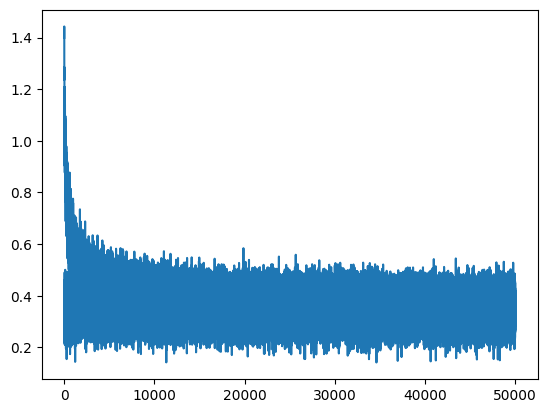

In [178]:
plt.plot(stepi, lossi)

In [179]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3033, grad_fn=<NllLossBackward0>)

In [180]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3499, grad_fn=<NllLossBackward0>)

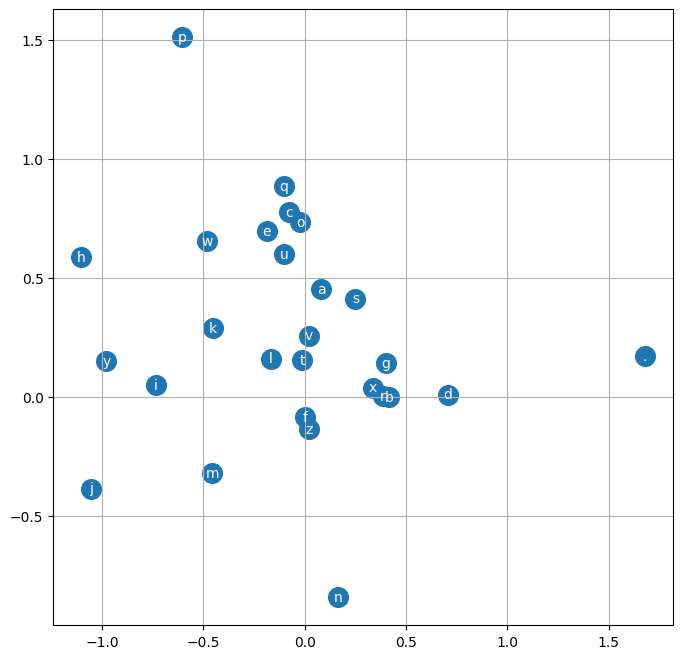

In [182]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [183]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    emb = C[torch.tensor([context])] # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mohavimyah.
meer.
niheyah.
remmadiendreem.
adeendettielley.
remreiellecianarielle.
malkelin.
shubergenitynette.
jewellerentencetusephederyyah.
fiel.
yumi.
myskolemehilina.
yansun.
zamilee.
ren.
cre.
kamiao.
caporenielynne.
bayleeiza.
amreyla.
